In [1]:
# Load packages and check versions
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.datasets import make_regression
from scipy.stats import linregress
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df = pd.read_csv('final_cleaned_data.csv')

In [3]:
features_response = df.columns.tolist()

In [4]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                   'PAY_6', 'EDUCATION_CAT', 'graduate school',
                   'high school' ,'others', 'university']

In [5]:
filtered_response = []
for item in features_response:
    if item not in items_to_remove:
        filtered_response.append(item)
features_response = filtered_response
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [6]:
corr = df[features_response].corr()
# corr.iloc[0:5,0:5]

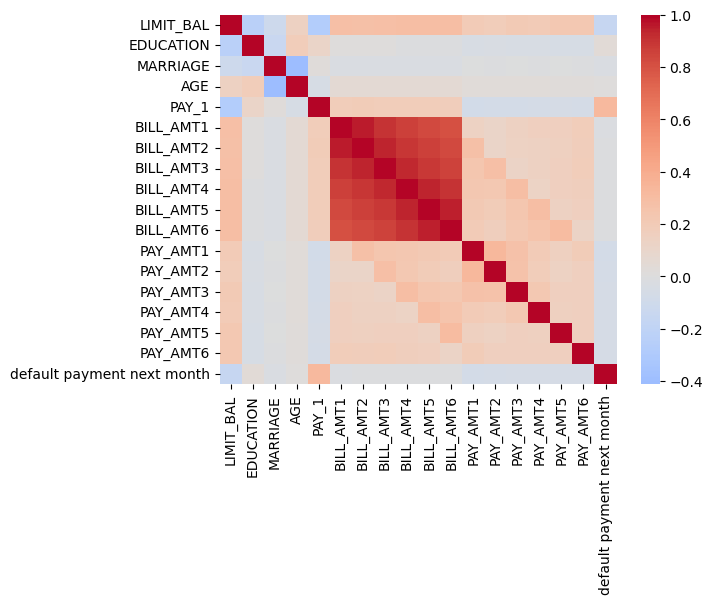

In [7]:
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Function to take in the polynomial coefficients and produce the y values

$$ Log Loss = \frac{1}{n}  \sum_{i=1}^n -( y_{i}log(p_{i}) + (1-y_{i})log(1-p_{i}) ) $$
We try and minimise the cross entropy loss

Overfitting is a common problem in machine learning, where a model performs very well on the training data but poorly on the test data, indicating poor generalization. A model that overfits the training data has high variance and has learned the noise or variability present in the training data too well. The bias-variance trade-off is a key concept in machine learning that involves balancing the complexity of a model with its ability to generalize to new data.   
On the other hand, if a model is not able to adequately capture the patterns in the training data, it is called underfitting. In such cases, the model has high bias, meaning it is too simple and lacks the complexity needed to capture the underlying patterns in the data. To counter this we can not blindly increase the number of high-degree polynomial terms as this leads to model instability and future predictions of the model would be badly predicted.

# Lasso (L1) Regularization

So we introduce bias into the training process itself by using regularization methods. 

Scikit-learn offers two types of regularization for logistic regression models, namely lasso (L1 regularization) and ridge (L2 regularization). The regularization effect adds a penalty or cost for having larger coefficient values in a fitted logistic regression model. The model object can be instantiated with penalty='l1' or penalty='l2' to choose the desired regularization type. Here we have attempted to perform it using L1 regularization

Lasso regularization or the L1 using 1-norm:
$$ \sum_{j=1}^m |\sigma_{j}| + \frac{c}{n}  \sum_{i=1}^n -( y_{i}log(p_{i}) + (1-y_{i})log(1-p_{i}) )$$

In addition to regularization, L1 penalty also performs feature selection by setting some coefficient values to zero, effectively removing them from the model. Note that the value C is a hyperparameter. 

#### Cross-Validation

In [8]:
n_folds = 4

In k-fold cross-validation, we don't specify the proportion of data directly. Instead, we specify the number of folds, which determines how the data will be divided into equal proportions. For example, if we choose 5 folds, each fold will contain 20% of the data, and the data will be trained and tested on five separate instances. In each fold, 80% of the data is used for training, while the remaining 20% is used for testing. This ensures that each data point is used once for testing and k-1 times for training.

In [9]:
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)

Subset out the features for the case study data

In [10]:
features = features_response[:-1]

In [11]:
X = df[features].values

Make a train/test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, df['default payment next month'].values, test_size=0.2, random_state=24)

To incorporate data scaling as part of the modeling process, we can use a Pipeline.

In [13]:
min_max_sc = MinMaxScaler()

In [14]:
lr = LogisticRegression(solver='saga', penalty='l1', max_iter=1000)

In [15]:
scale_lr_pipeline = Pipeline(steps=[('scaler', min_max_sc), ('model', lr)])

In [16]:
scale_lr_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('model', LogisticRegression(max_iter=1000, penalty='l1', solver='saga'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': LogisticRegression(max_iter=1000, penalty='l1', solver='saga'),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 1000,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'saga',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [17]:
scale_lr_pipeline.get_params()['model__C']

1.0

In [18]:
scale_lr_pipeline.set_params(model__C = 2)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=2, max_iter=1000, penalty='l1',
                                    solver='saga'))])

varying the regularization parameters

In [19]:
C_val_exponents = np.arange(2, -4, -1)
C_vals = float(10)**C_val_exponents
C_vals

array([1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

In [20]:
def cross_val_C_search_pipe(k_folds, C_vals, estimator, X, y):
    # initialize arrays to store results
    n_folds = k_folds.n_splits
    train_scores = np.empty((n_folds, len(C_vals)))
    test_scores = np.empty((n_folds, len(C_vals)))
    test_roc_curves = [[] for _ in range(len(C_vals))]

    # loop over different values of C
    for c_val_counter, C in enumerate(C_vals):
        # set the C value for the estimator object
        estimator.set_params(model__C=C)

        # loop over each fold
        for fold_counter, (train_index, test_index) in enumerate(k_folds.split(X, y)):
            # Subset the features and response for training and testing data for this fold
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Fit the model on the training data
            estimator.fit(X_train, y_train)

            # Get the training and testing ROC AUC scores
            y_train_proba = estimator.predict_proba(X_train)[:, 1]
            train_scores[fold_counter, c_val_counter] = roc_auc_score(y_train, y_train_proba)

            y_test_proba = estimator.predict_proba(X_test)[:, 1]
            test_scores[fold_counter, c_val_counter] = roc_auc_score(y_test, y_test_proba)

            # Get the testing ROC curves for this fold
            this_fold_roc = roc_curve(y_test, y_test_proba)
            test_roc_curves[c_val_counter].append(this_fold_roc)

        print(f"Done with C = {C}")

    return train_scores, test_scores, test_roc_curves

In [21]:
%%time
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001
CPU times: total: 30.2 s
Wall time: 27.1 s


Text(0.5, 1.0, 'Cross-validation on Case Study problem')

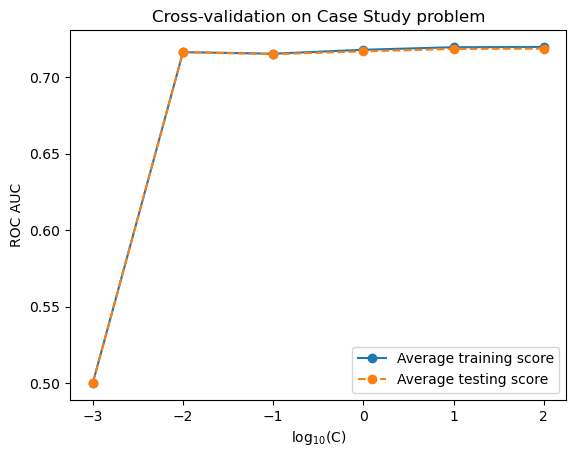

In [22]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o', label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '--o', label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross-validation on Case Study problem')

Our model performance is bad only for a small value of C. However as the value of C increases we see that the model performance is still relatively good. This means that we are not overfitting, but instead could be underfitting our data. So let us try out some interactive features to see if we can improve our performance. 

In [23]:
make_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interact = make_interactions.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split( X_interact, df['default payment next month'].values, \
                                                    test_size=0.2, random_state=24)

In [25]:
%%time
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

c:\Users\rahna\miniconda3\envs\dspwp2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rahna\miniconda3\envs\dspwp2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rahna\miniconda3\envs\dspwp2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rahna\miniconda3\envs\dspwp2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C = 100.0


c:\Users\rahna\miniconda3\envs\dspwp2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rahna\miniconda3\envs\dspwp2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rahna\miniconda3\envs\dspwp2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rahna\miniconda3\envs\dspwp2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C = 10.0


c:\Users\rahna\miniconda3\envs\dspwp2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rahna\miniconda3\envs\dspwp2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rahna\miniconda3\envs\dspwp2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001
CPU times: total: 9min 13s
Wall time: 9min 5s


Text(0.5, 1.0, 'Cross-validation on Case Study problem')

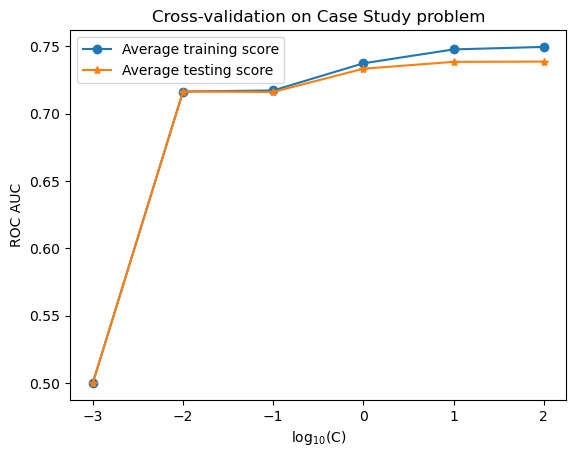

In [26]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o', label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-*', label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross-validation on Case Study problem')

The plot of training versus test scores for the model with interactions suggests some overfitting, as the training score is slightly higher than the test score. However, regularization may not be helpful in improving the test score. The addition of interaction features improved the cross-validation performance of the logistic regression model in the case study. Overall, the best strategy is usually the one that yields the highest test score.